In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [5]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifierCV(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  scores = cross_validate(clf, X_train, y_train, scoring=['accuracy', 'roc_auc_ovo_weighted', 'roc_auc_ovr_weighted'], cv=cv, return_estimator=True, return_train_score=True)
  ### END CODE ###
  if supress_outputs == False:
      print("CV time", round(time()-t0, 3), "s")

  estimators = scores['estimator']
  del scores['estimator']
  scores = pd.DataFrame(scores).T
  summary = scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

  if supress_outputs == False:
      display(summary[['mean', 'std']])

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results, summary

In [6]:
df_orig = pd.read_csv('dataset/train.csv')
df_orig = df_orig.drop(columns='id')

df_orig = reduce_memory_usage(df_orig, verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 1.74 Mb (35.3% reduction)
memory GB:0.22
Memory reduced


In [7]:
y_orig = df_orig['NObeyesdad']
X_orig = df_orig.drop(columns='NObeyesdad')

# y_orig = df_lean['NObeyesdad']
# X_lean = df_lean.drop(columns='NObeyesdad')

In [8]:
df1 = pd.read_csv('dataset/ObesityDataSet.csv')

df2 = pd.read_csv('dataset/train.csv')
df2 = df2.drop(columns='id')

df = pd.concat([df1, df2], ignore_index=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.000000,3.000000,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
22865,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
22866,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
22867,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [9]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [10]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [11]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]

WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]

CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]

CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]

In [12]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [13]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obseity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obseity class 2')
            else:
                pred.append('obseity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [14]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [15]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.66 Mb (30.7% reduction)
memory GB:0.24
Memory reduced


features obtained


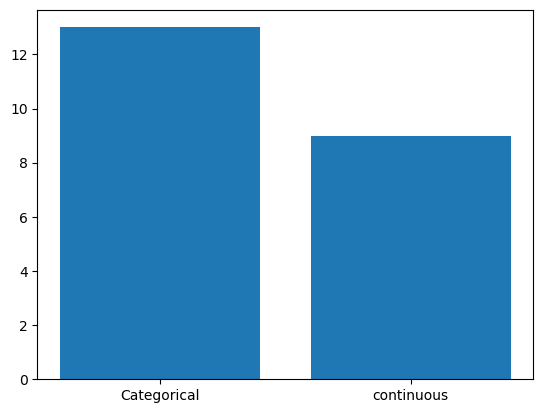

CPU times: total: 109 ms
Wall time: 98.9 ms


In [16]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [17]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [18]:
cat_features.remove('NObeyesdad')
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [19]:
nominal_features = [cat_features[i] for i in [0, 1, 2, 4, 5, 7, 9]]
print(nominal_features)

ordinal_features = [cat_features[i] for i in [3, 6, 9, 10, 11]]
print(ordinal_features)

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS', 'Adult BMI Predictions']
['CAEC', 'CALC', 'Adult BMI Predictions', 'WHO BMI Predictions', 'CDC BMI Predictions']


In [20]:
# Manual encoding
manual_enc = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [21]:
# Manual encoding
col_enc1 = ColumnTransformer(
    [
        ('numerical', 'passthrough', cont_features),
        ('ordinal', OrdinalEncoder(categories=[
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['no', 'Sometimes', 'Frequently', 'Always'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3'],
            ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']
        ]), ordinal_features),
        ('nominal', OneHotEncoder(sparse_output=False), nominal_features)
    ], verbose_feature_names_out=False
)

In [22]:
col_enc2 = ColumnTransformer(
    [
        ('numerIteract', Pipeline(
            [
                ('interact', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                ('scale', StandardScaler())
            ]), slice(0, 9)),
        ('catInteract', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), slice(14, 31))
    ], verbose_feature_names_out=False
)

manual_enc2 = Pipeline([('Categorical Preprocessing', col_enc1), ('Interaction Terms', col_enc2)])

In [23]:
ordinalCT = OrdinalEncoder()

ordinalCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ], verbose_feature_names_out=False
    )

# Removed due to memory issues
# oneHotCT = OneHotEncoder() 


oneHotCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

oneHotCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ], verbose_feature_names_out=False
    )

CTs = [ordinalCT, ordinalCatOnlyCT, ordinalCatStandardCT, ordinalCatRobustCT, 
       # oneHotCT, 
       oneHotCatOnlyCT, oneHotCatStandardCT, oneHotCatRobustCT, manual_enc, manual_enc2]
preprocessed = ["(Ordinal)", "(Ordinal Categorical Only - No Scaling)", "(Ordinal Categorical Only - Standard Scaler)", "(Ordinal Categorical Only - Robust Scaler)",
                # "(One Hot)", 
                "(One Hot Categorical Only - No Scaling)", "(One Hot Categorical Only - Standard Scaler)", "(One Hot Categorical Only - Robust Scaler)",
               'Manual Encoding 1', 'Manual Encoding 2']

if len(CTs) != len(preprocessed):
    print("NUMBER OF TRANSFORMERS != NUMBER OF PREPROCESSED DATASETS") 

In [24]:
# TEST WITH DIFFERENT ENCODERS: ORDINAL, ONE-HOT, TARGET
lean = True
if lean == True:
    X_split = X_lean
    y_split = y_lean
else:
    X_split = X
    y_split = y

X_s = []
for i, CT in enumerate(CTs):
    # print(i)
    X_s.append(CT.fit_transform(X_split.copy(), y_split))

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y_split, test_size=1/4, random_state=42)


In [25]:
X_orig = OrdinalEncoder().fit_transform(X_orig, y)

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=1/4, random_state=42)
X_train.append(X_train_orig)
X_test.append(X_test_orig)
y_train.append(y_train_orig)
y_test.append(y_test_orig)
preprocessed.append('Original DataSet')

Decision Tree (Ordinal)
CV time 1.625 s


,mean,std
fit_time,0.151726,2.293407e-03
score_time,0.041369,5.232295e-04
test_accuracy,0.852079,4.967993e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.909654,3.149799e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.914772,2.868454e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.007 s
Confusion matrix: 


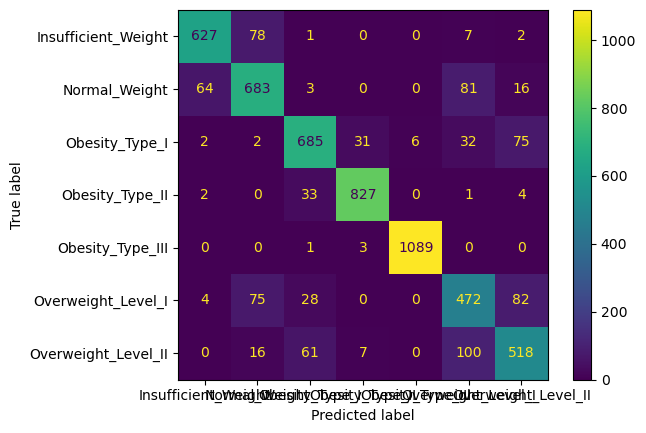

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8571178733823015, AUC_ROC_OVO: 0.9090925351360761, AUC_ROC_OVR: 0.9103340060200917

Decision Tree (Ordinal Categorical Only - No Scaling)
CV time 1.635 s


,mean,std
fit_time,0.152612,1.407632e-03
score_time,0.041857,6.208570e-04
test_accuracy,0.849746,2.930603e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.908317,1.882313e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.913421,1.651152e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.009 s
Confusion matrix: 


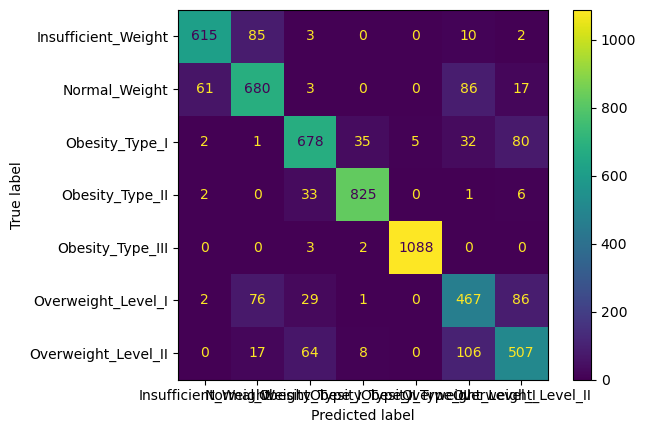

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8499475341028332, AUC_ROC_OVO: 0.9044934748778735, AUC_ROC_OVR: 0.9058022312062871

Decision Tree (Ordinal Categorical Only - Standard Scaler)
CV time 1.631 s


,mean,std
fit_time,0.151906,2.318254e-03
score_time,0.042497,1.872747e-03
test_accuracy,0.851496,2.935903e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.909392,1.682022e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.914388,1.686554e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.009 s
Confusion matrix: 


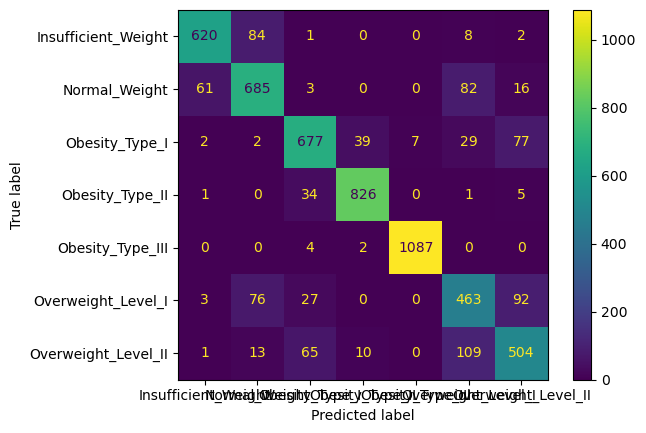

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8502973067506121, AUC_ROC_OVO: 0.9046274241850772, AUC_ROC_OVR: 0.9059420712839109

Decision Tree (Ordinal Categorical Only - Robust Scaler)
CV time 1.648 s


,mean,std
fit_time,0.152761,1.348038e-03
score_time,0.042882,1.048677e-03
test_accuracy,0.851729,4.794645e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.909499,2.910694e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.914513,2.733150e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.008 s
Confusion matrix: 


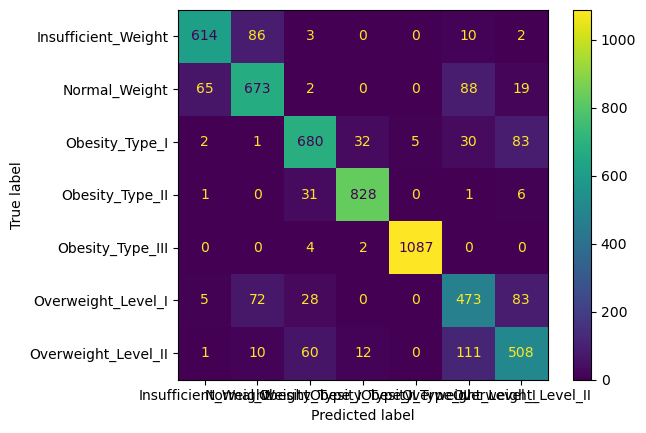

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8504721930745016, AUC_ROC_OVO: 0.904975675323255, AUC_ROC_OVR: 0.9062654730940729

Decision Tree (One Hot Categorical Only - No Scaling)
CV time 1.804 s


,mean,std
fit_time,0.175088,2.835886e-03
score_time,0.043701,1.212675e-03
test_accuracy,0.847764,3.192570e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.907104,1.983940e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.912285,1.887646e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.011 s
Confusion matrix: 


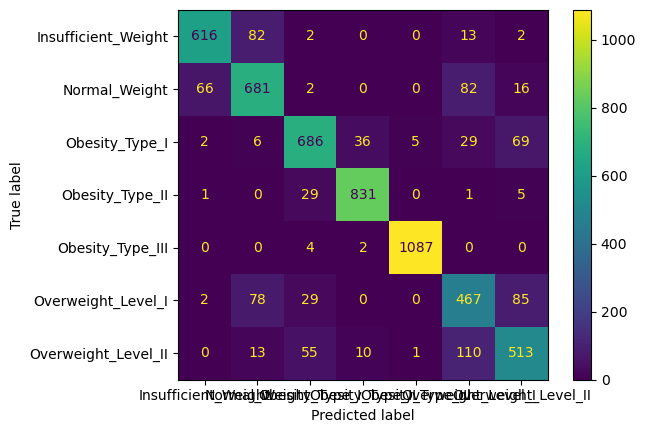

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.853620146904512, AUC_ROC_OVO: 0.9067091426772468, AUC_ROC_OVR: 0.9080031424902734

Decision Tree (One Hot Categorical Only - Standard Scaler)
CV time 1.798 s


,mean,std
fit_time,0.173364,4.107799e-03
score_time,0.043034,1.090009e-03
test_accuracy,0.846656,3.516483e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.906426,2.089531e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.911608,2.003423e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.011 s
Confusion matrix: 


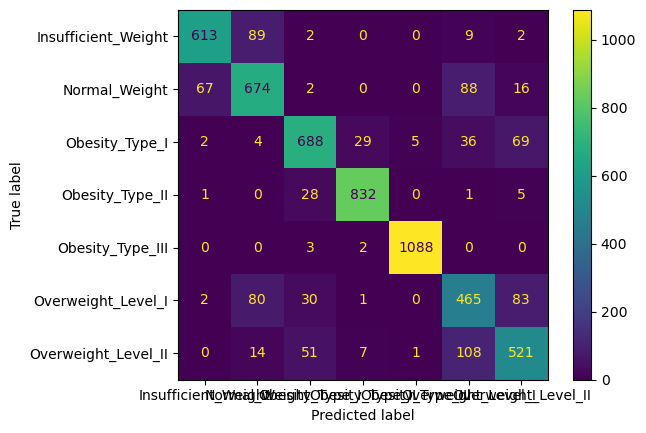

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.853620146904512, AUC_ROC_OVO: 0.9067533384676714, AUC_ROC_OVR: 0.9080450083796797

Decision Tree (One Hot Categorical Only - Robust Scaler)
CV time 1.797 s


,mean,std
fit_time,0.174715,2.418767e-03
score_time,0.043107,1.019645e-03
test_accuracy,0.848172,4.071028e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.907325,2.658543e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.912519,2.371189e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.012 s
Confusion matrix: 


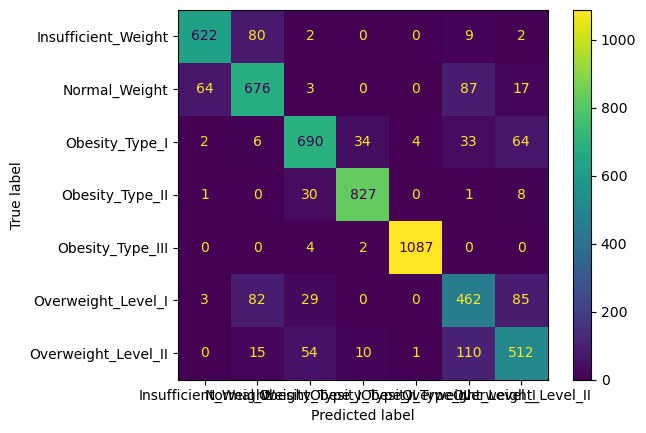

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8527457152850647, AUC_ROC_OVO: 0.906195619242477, AUC_ROC_OVR: 0.9074928291814766

Decision Tree Manual Encoding 1
CV time 1.754 s


,mean,std
fit_time,0.169035,2.116945e-03
score_time,0.043002,1.008886e-03
test_accuracy,0.849979,4.703143e-03
train_accuracy,0.999898,5.830426e-05
test_roc_auc_ovo_weighted,0.908376,2.908251e-03
train_roc_auc_ovo_weighted,1.000000,9.257741e-09
test_roc_auc_ovr_weighted,0.913523,2.735282e-03
train_roc_auc_ovr_weighted,1.000000,7.639538e-09


predict time 0.01 s
Confusion matrix: 


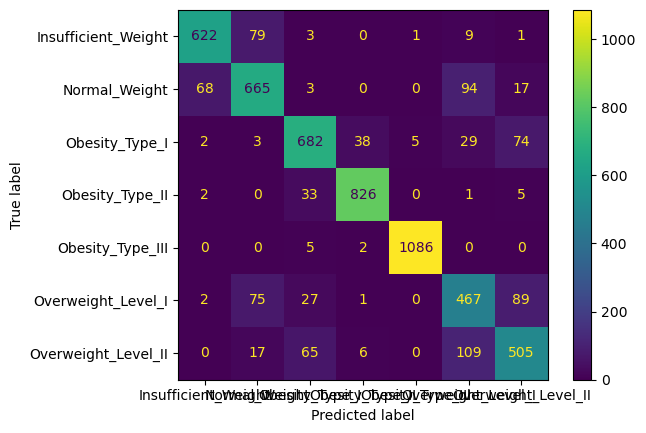

TRAIN - Accuracy: 0.9998833887236895, AUC_ROC_OVO: 0.999999983416084, AUC_ROC_OVR: 0.9999999862646322
TEST - Accuracy: 0.8487233298356068, AUC_ROC_OVO: 0.9039399917475363, AUC_ROC_OVR: 0.9052287602336081

Decision Tree Manual Encoding 2
CV time 8.017 s


,mean,std
fit_time,1.151346,1.559367e-02
score_time,0.049116,9.147293e-04
test_accuracy,0.841759,4.788578e-03
train_accuracy,0.999329,5.453658e-05
test_roc_auc_ovo_weighted,0.903632,3.192090e-03
train_roc_auc_ovo_weighted,1.000000,3.624713e-08
test_roc_auc_ovr_weighted,0.908889,2.923114e-03
train_roc_auc_ovr_weighted,1.000000,3.259400e-08


predict time 0.028 s
Confusion matrix: 


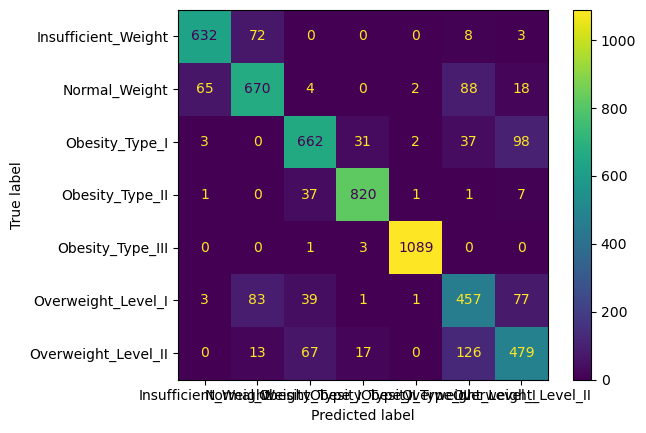

TRAIN - Accuracy: 0.9991837210658271, AUC_ROC_OVO: 0.9999995628109744, AUC_ROC_OVR: 0.9999996168279186
TEST - Accuracy: 0.8410283315844701, AUC_ROC_OVO: 0.8995118566959636, AUC_ROC_OVR: 0.9008878283511975

Decision Tree Original DataSet
CV time 1.246 s


,mean,std
fit_time,0.103347,0.001379
score_time,0.038591,0.000537
test_accuracy,0.841278,0.004263
train_accuracy,1.000000,0.000000
test_roc_auc_ovo_weighted,0.902872,0.002644
train_roc_auc_ovo_weighted,1.000000,0.000000
test_roc_auc_ovr_weighted,0.908579,0.002472
train_roc_auc_ovr_weighted,1.000000,0.000000


predict time 0.006 s
Confusion matrix: 


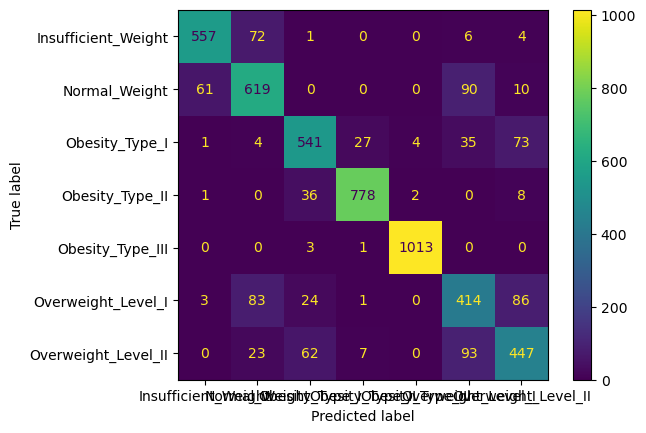

TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.8418111753371869, AUC_ROC_OVO: 0.8981363878551287, AUC_ROC_OVR: 0.8996841271874805



,cv_test_mean,cv_test_std
(Ordinal),0.852079,0.004968
(Ordinal Categorical Only - No Scaling),0.849746,0.002931
(Ordinal Categorical Only - Standard Scaler),0.851496,0.002936
(Ordinal Categorical Only - Robust Scaler),0.851729,0.004795
(One Hot Categorical Only - No Scaling),0.847764,0.003193
(One Hot Categorical Only - Standard Scaler),0.846656,0.003516
(One Hot Categorical Only - Robust Scaler),0.848172,0.004071
Manual Encoding 1,0.849979,0.004703
Manual Encoding 2,0.841759,0.004789
Original DataSet,0.841278,0.004263


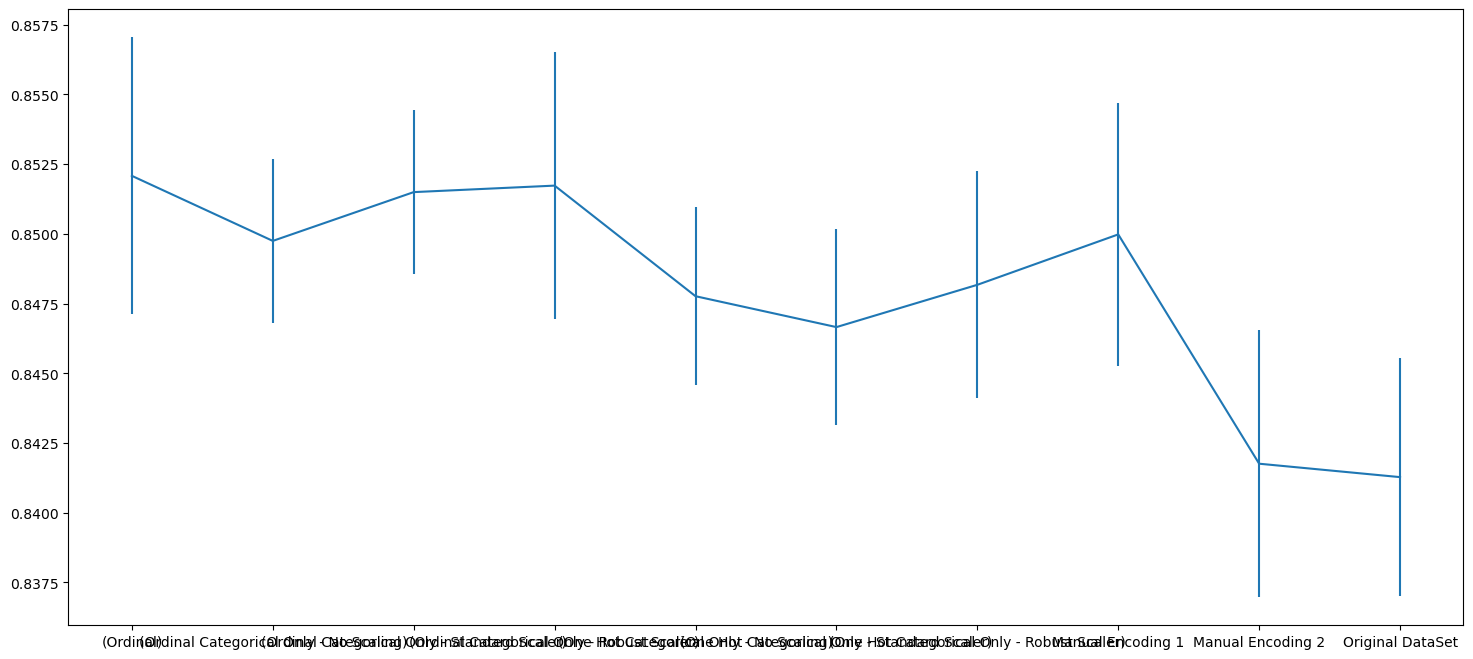

Best Preprocessing: (Ordinal) - Test Accuracy: 0.8571178733823015


In [26]:
# Model 1 - Decision Tree
test = []
models = []
summaries = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"Decision Tree {name}", 
                                                                            model, 
                                                                            X_train[i], 
                                                                            y_train[i], 
                                                                            X_test[i], 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

(17151, 21, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


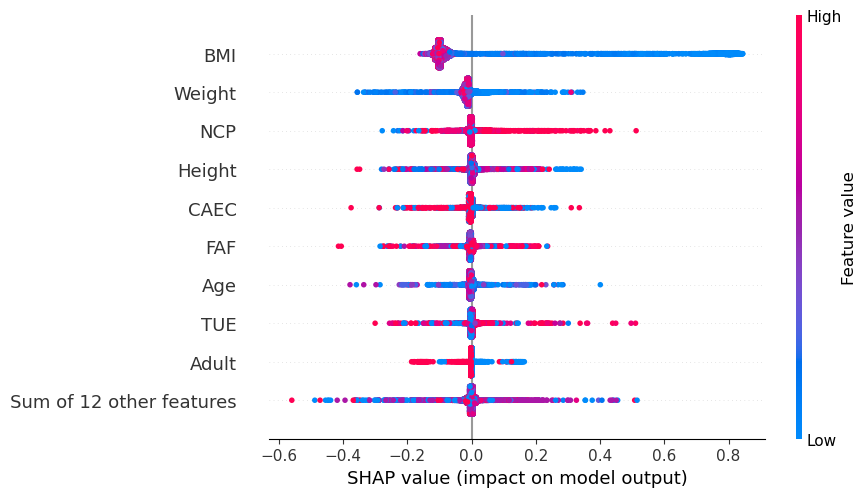

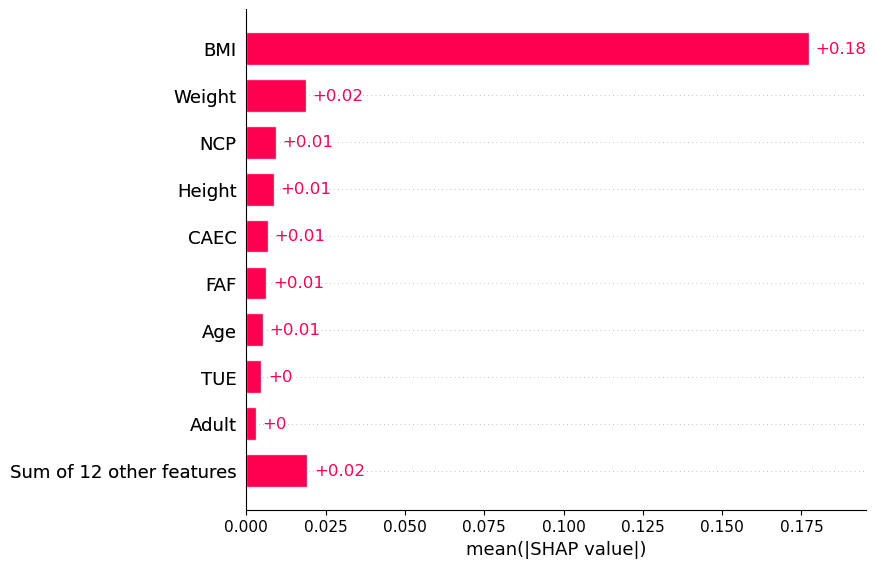

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


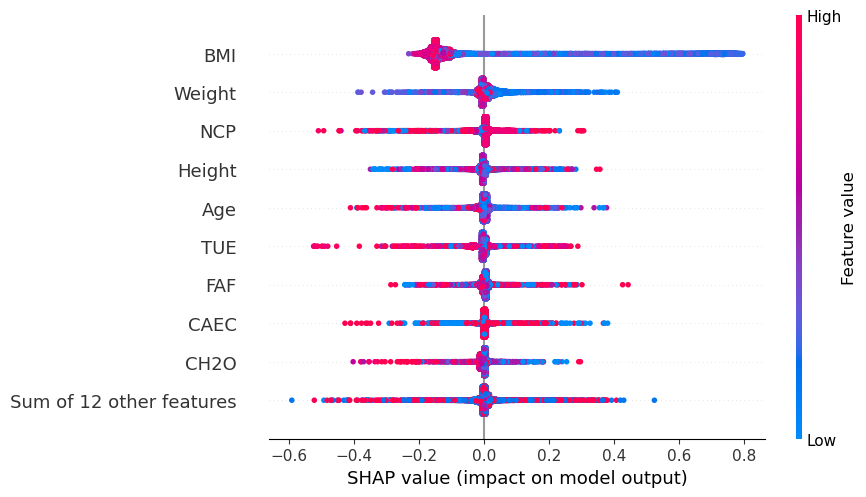

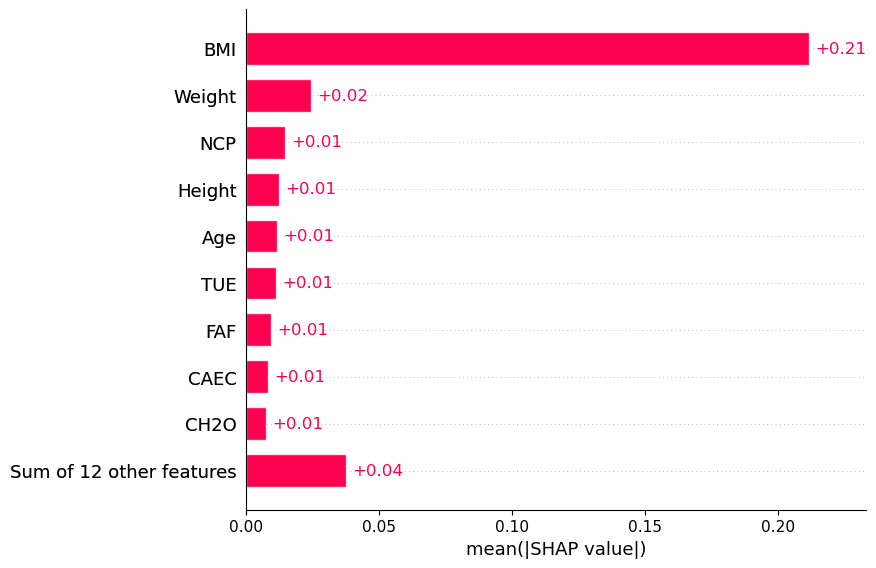

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


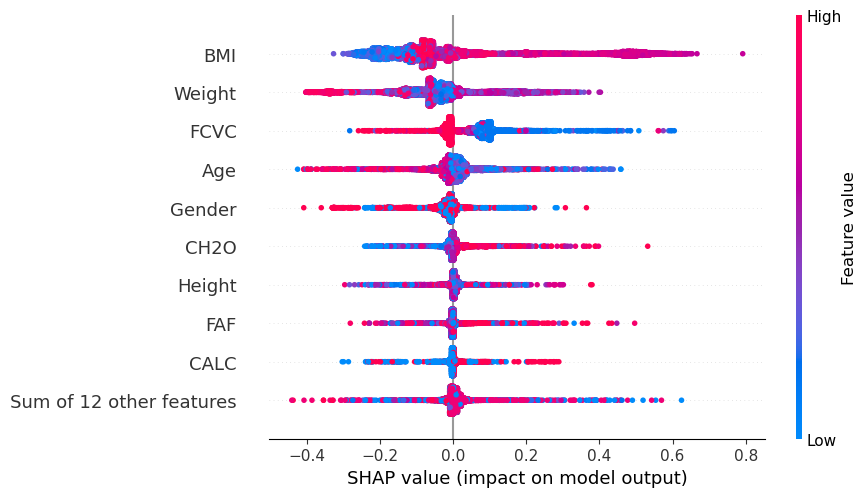

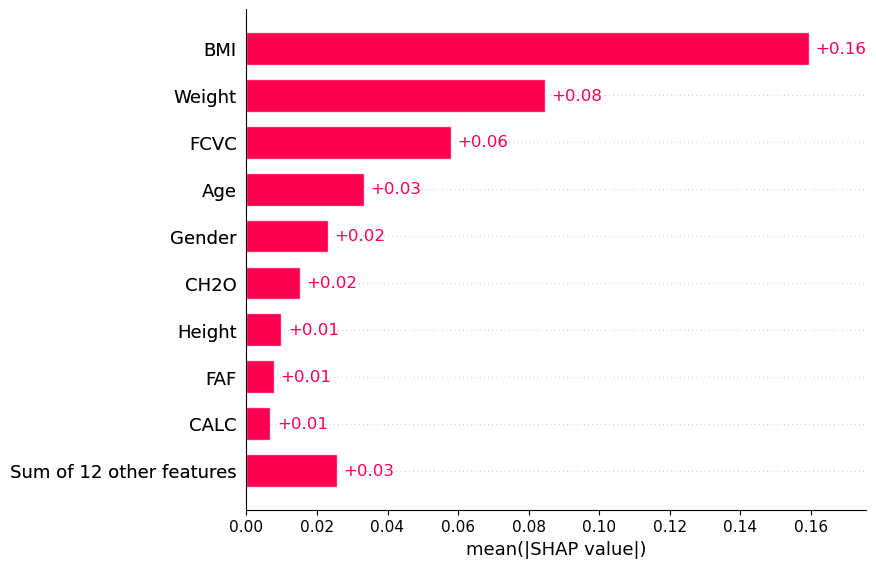

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


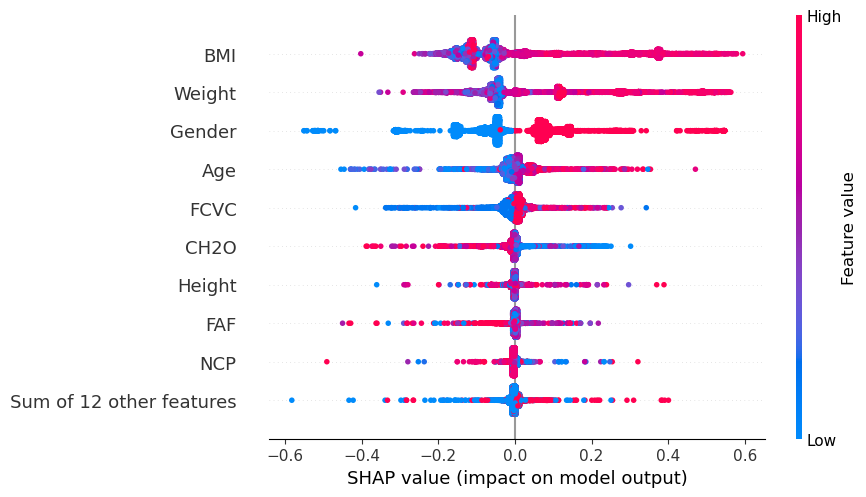

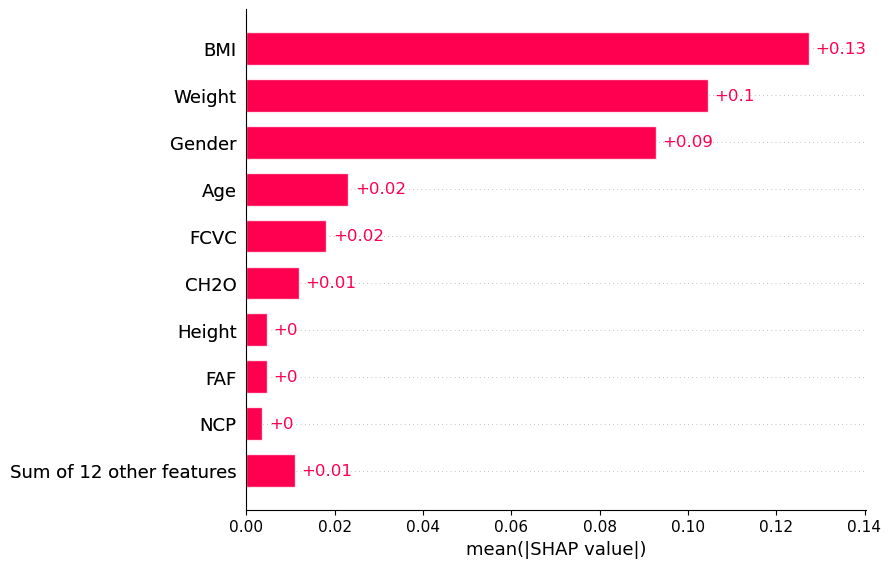

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


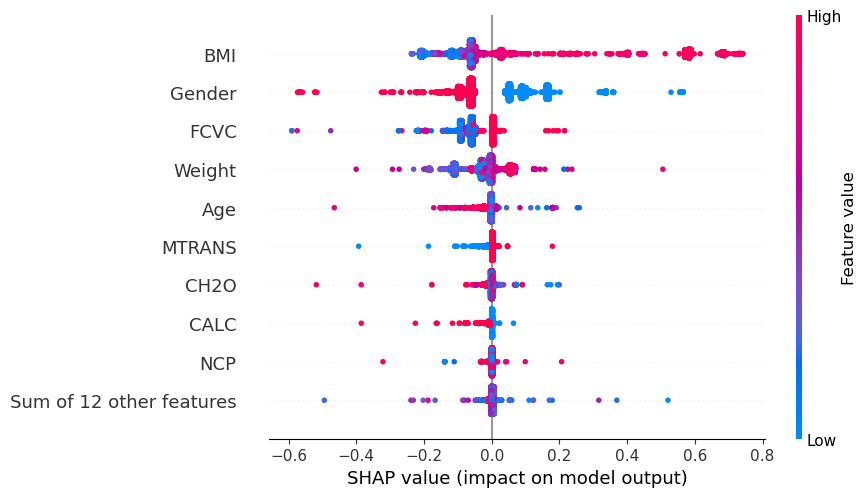

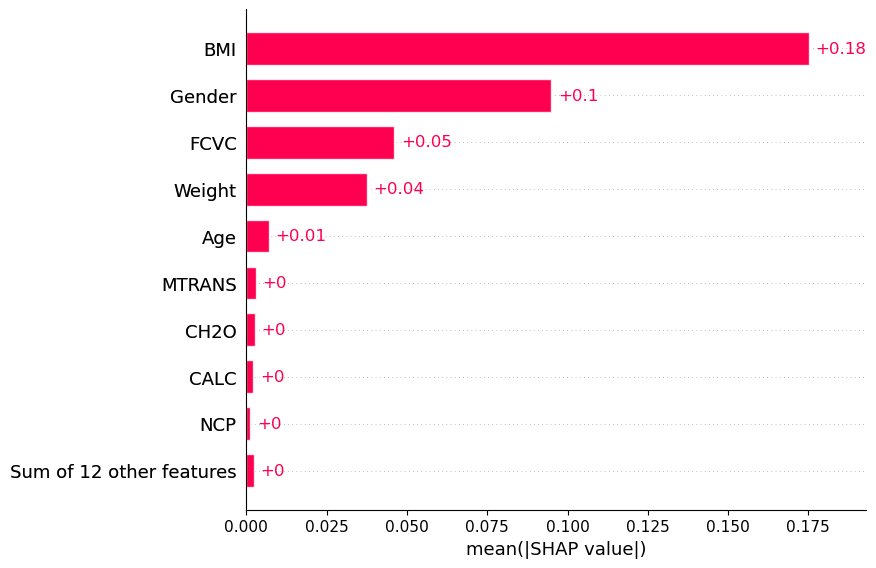

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


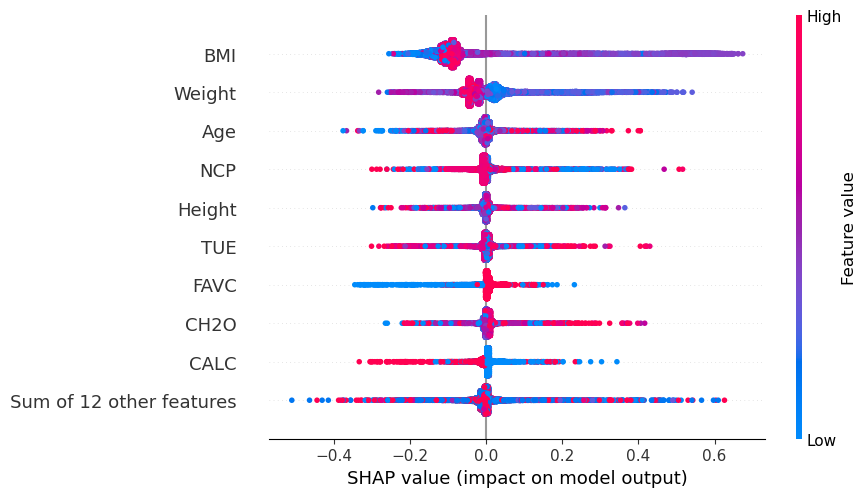

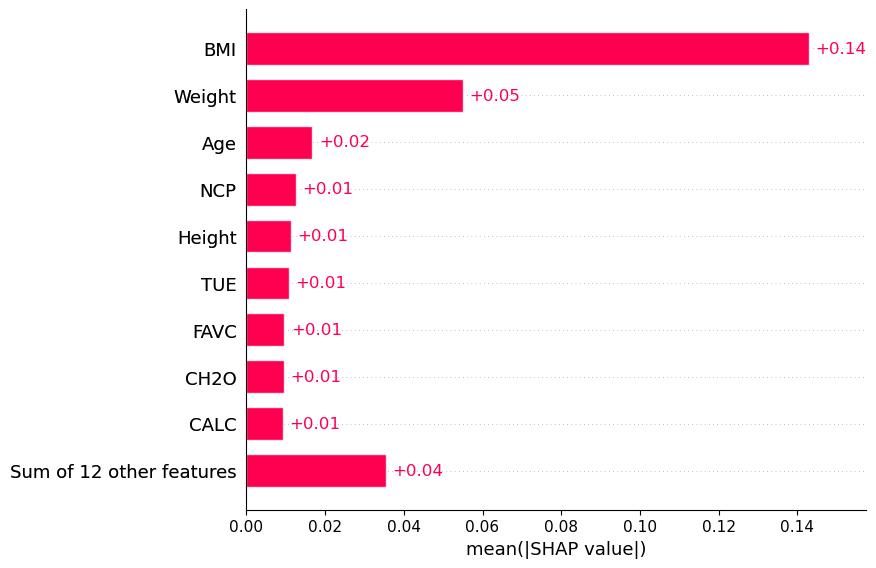

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


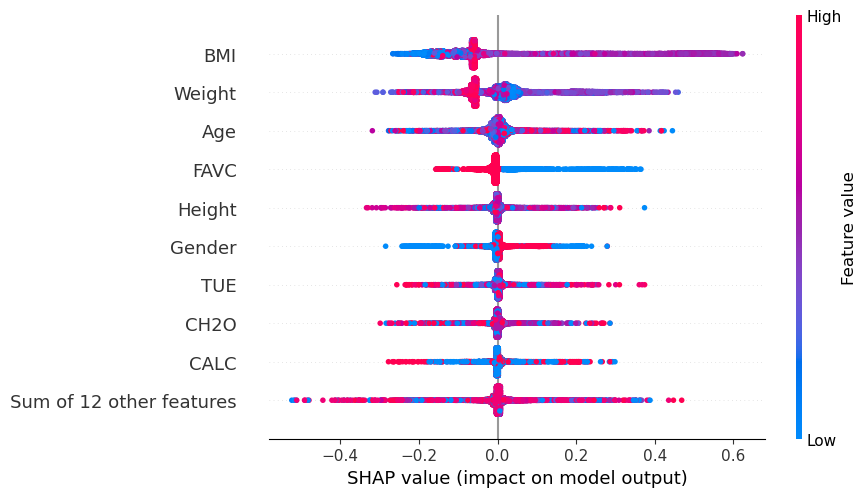

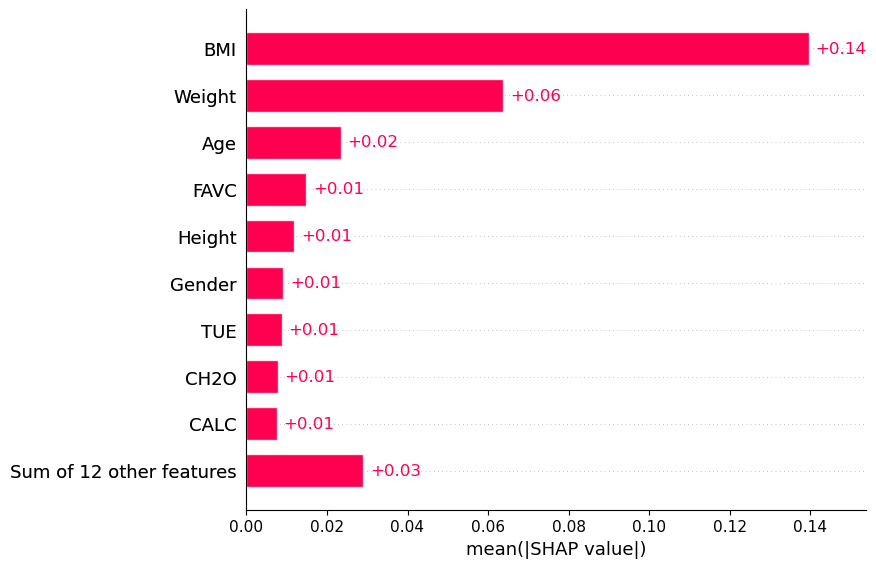

In [27]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_model)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [28]:
preprocessed[-2:]

['Manual Encoding 2', 'Original DataSet']

Logistic Regression Manual Encoding 2


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 75.739 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,mean,std
fit_time,11.908100,0.265355
score_time,0.046629,0.000217
test_accuracy,0.864672,0.004745
train_accuracy,0.866655,0.002375
test_roc_auc_ovo_weighted,0.979537,0.001103
train_roc_auc_ovo_weighted,0.980087,0.000376
test_roc_auc_ovr_weighted,0.981611,0.001023
train_roc_auc_ovr_weighted,0.982113,0.000342


predict time 0.004 s
Confusion matrix: 


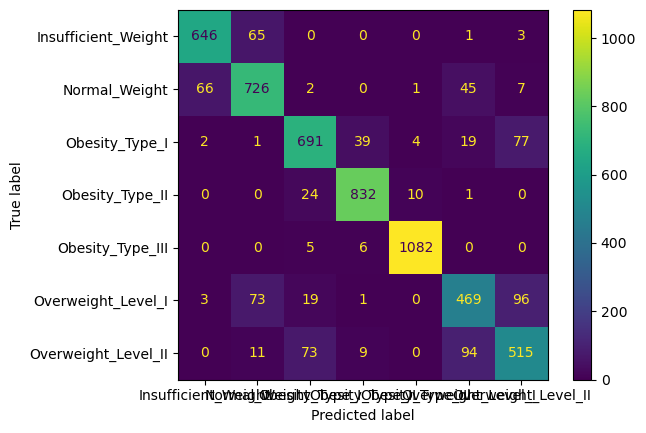

TRAIN - Accuracy: 0.866188560433794, AUC_ROC_OVO: 0.9782507696301892, AUC_ROC_OVR: 0.9804362702304982
TEST - Accuracy: 0.8676110528156699, AUC_ROC_OVO: 0.9777182214388986, AUC_ROC_OVR: 0.9798444480452805

Logistic Regression Original DataSet


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV time 75.253 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,mean,std
fit_time,11.872660,0.546855
score_time,0.045933,0.000933
test_accuracy,0.873301,0.004762
train_accuracy,0.876217,0.002564
test_roc_auc_ovo_weighted,0.980671,0.001251
train_roc_auc_ovo_weighted,0.981488,0.000656
test_roc_auc_ovr_weighted,0.982610,0.001157
train_roc_auc_ovr_weighted,0.983360,0.000594


predict time 0.005 s
Confusion matrix: 


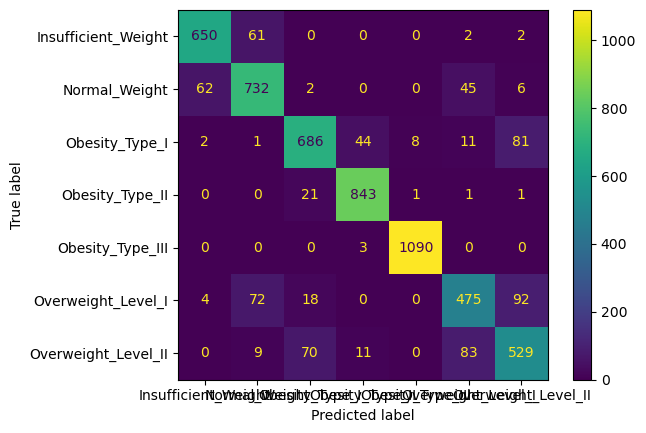

TRAIN - Accuracy: 0.8772083260451286, AUC_ROC_OVO: 0.9799800015028038, AUC_ROC_OVR: 0.9819718441393945
TEST - Accuracy: 0.8753060510668066, AUC_ROC_OVO: 0.9789173011581253, AUC_ROC_OVR: 0.9809251974081008



,cv_test_mean,cv_test_std
Manual Encoding 2,0.864672,0.004745
Original DataSet,0.873301,0.004762


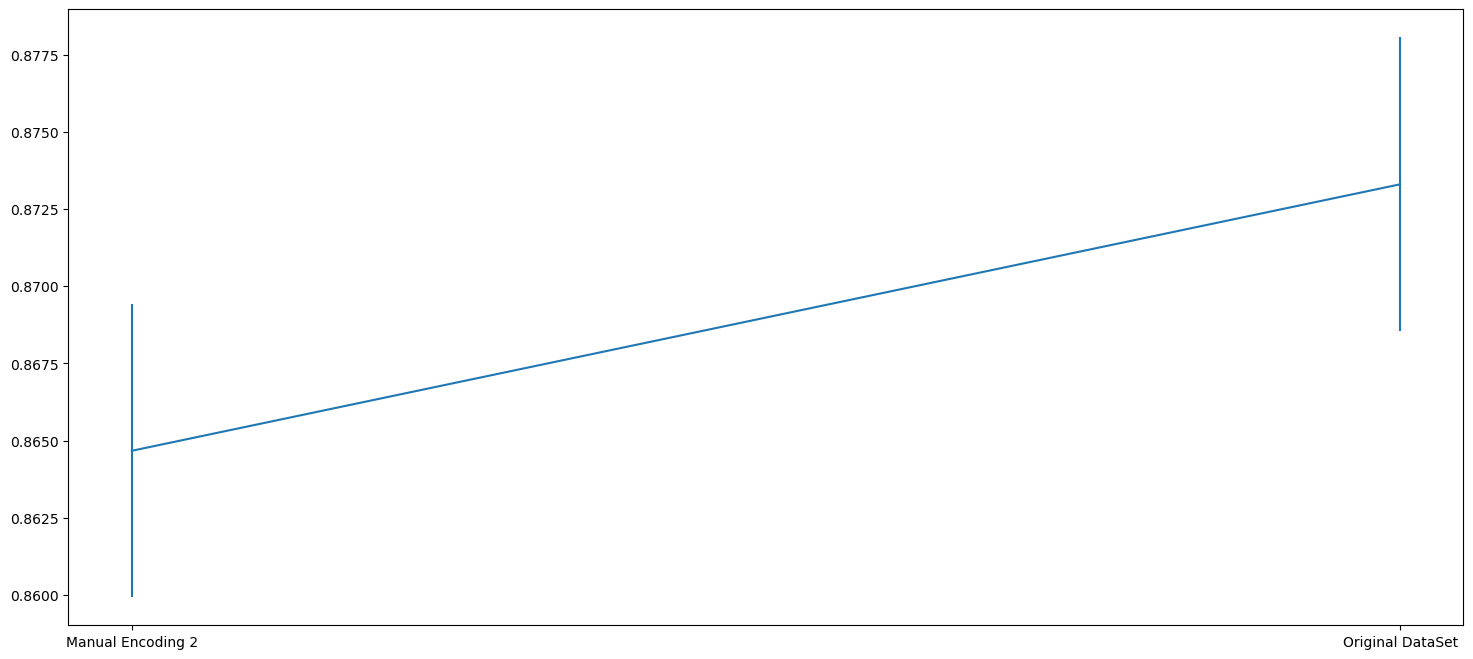

Best Preprocessing: (Ordinal Categorical Only - No Scaling) - Test Accuracy: 0.8753060510668066


In [29]:
# Model 2a - Logistic Regression
tests = []
models = []
summaries = []
# test = preprocessed[len(preprocessed)-1]
for i, name in enumerate(preprocessed[-2:]):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results, summary = train_and_evaluate_classifierCV(f"Logistic Regression {name}", 
                                                                            model, 
                                                                            X_train[i], 
                                                                            y_train[i], 
                                                                            X_test[i], 
                                                                            y_test[i], 
                                                                            confusion=True, 
                                                                            supress_outputs=False)
    tests.append(test_results[0])
    models.append(model)
    summaries.append(summary)
    print()

cv_test_mean = [summary['mean']['test_accuracy'] for summary in summaries]
cv_test_std =  [summary['std']['test_accuracy'] for summary in summaries]
cv_results = pd.DataFrame({'cv_test_mean':cv_test_mean, 'cv_test_std':cv_test_std})
cv_results.index = preprocessed[-2:]
display(cv_results)
plt.figure(figsize=(18, 8))
plt.errorbar(cv_results.index, cv_results['cv_test_mean'], yerr=cv_results['cv_test_std'])
plt.show()

tests = np.array(tests)
loc_best_test = np.argmax(tests)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {tests[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

In [30]:
X_orig

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,1.0,404.0,195.0,382.0,1.0,1.0,198.0,387.0,2.0,0.0,758.0,0.0,0.0,821.0,1.0,3.0
1,0.0,57.0,58.0,160.0,1.0,1.0,198.0,396.0,1.0,0.0,465.0,0.0,595.0,832.0,2.0,0.0
2,0.0,57.0,207.0,86.0,1.0,1.0,156.0,93.0,2.0,0.0,413.0,0.0,478.0,1028.0,2.0,3.0
3,0.0,216.0,206.0,887.0,1.0,1.0,576.0,396.0,2.0,0.0,296.0,0.0,790.0,644.0,1.0,3.0
4,1.0,635.0,392.0,523.0,1.0,1.0,445.0,181.0,2.0,0.0,451.0,0.0,996.0,780.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1.0,431.0,262.0,746.0,1.0,1.0,539.0,396.0,2.0,0.0,533.0,0.0,736.0,212.0,1.0,3.0
20754,1.0,57.0,205.0,84.0,0.0,1.0,576.0,522.0,1.0,0.0,0.0,0.0,1022.0,832.0,1.0,3.0
20755,1.0,172.0,315.0,646.0,1.0,1.0,356.0,396.0,2.0,0.0,465.0,0.0,657.0,884.0,2.0,3.0
20756,1.0,677.0,195.0,407.0,1.0,1.0,443.0,181.0,2.0,0.0,529.0,0.0,0.0,818.0,2.0,0.0


In [31]:
X_train[9]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
10300,0.0,110.0,185.0,262.0,0.0,1.0,576.0,396.0,2.0,0.0,465.0,0.0,0.0,0.0,2.0,4.0
20166,1.0,829.0,203.0,364.0,1.0,1.0,198.0,396.0,2.0,0.0,465.0,0.0,595.0,954.0,2.0,0.0
18790,0.0,307.0,144.0,400.0,1.0,1.0,198.0,0.0,2.0,0.0,465.0,0.0,1124.0,832.0,2.0,3.0
829,0.0,57.0,85.0,128.0,0.0,1.0,198.0,396.0,1.0,0.0,465.0,0.0,0.0,1109.0,1.0,3.0
8267,0.0,188.0,39.0,24.0,0.0,1.0,538.0,0.0,1.0,0.0,149.0,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,57.0,218.0,370.0,1.0,1.0,426.0,266.0,2.0,0.0,383.0,0.0,219.0,589.0,2.0,3.0
11964,1.0,278.0,245.0,532.0,1.0,0.0,576.0,396.0,2.0,0.0,465.0,0.0,1132.0,0.0,1.0,3.0
5390,1.0,219.0,113.0,251.0,0.0,1.0,198.0,396.0,0.0,0.0,855.0,0.0,1022.0,0.0,1.0,3.0
860,0.0,473.0,144.0,716.0,1.0,1.0,576.0,396.0,2.0,0.0,762.0,0.0,0.0,248.0,1.0,3.0


In [32]:
X_train[8]

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Age Height,...,MTRANS_Motorbike MTRANS_Public_Transportation,MTRANS_Motorbike MTRANS_Walking,MTRANS_Motorbike Adult BMI Predictions_N/A,MTRANS_Motorbike Adult BMI Predictions_healthy,MTRANS_Public_Transportation MTRANS_Walking,MTRANS_Public_Transportation Adult BMI Predictions_N/A,MTRANS_Public_Transportation Adult BMI Predictions_healthy,MTRANS_Walking Adult BMI Predictions_N/A,MTRANS_Walking Adult BMI Predictions_healthy,Adult BMI Predictions_N/A Adult BMI Predictions_healthy
17719,-1.023438,0.220215,-0.711914,-0.831543,0.344727,-0.045074,2.400391,0.629395,-0.826172,-0.973633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21911,-0.107727,1.965820,1.269531,1.043945,-0.082886,1.103516,-0.522461,-1.029297,0.526367,0.297852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7307,-0.501465,-0.235474,-1.243164,-0.831543,0.344727,-0.045074,2.400391,-1.029297,-1.289062,-0.536621,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13904,0.356689,-0.868652,0.554199,1.043945,0.344727,-1.635742,-1.141602,-0.582520,1.037109,0.152954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16414,-0.803223,0.342285,1.701172,1.043945,0.344727,0.670410,0.724609,-0.077637,1.696289,-0.731934,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,4.886719,-1.146484,0.388184,-0.831543,0.344727,-0.045074,-1.172852,2.289062,0.973633,4.292969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21575,0.367676,-1.479492,-1.052734,1.043945,0.344727,-0.045074,-1.172852,-1.029297,-0.704102,0.020676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.354004,0.720215,1.000000,-0.840332,0.344727,0.089600,-0.323486,0.247803,0.782227,0.515625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,-0.675293,1.331055,-0.104980,0.952148,0.344727,1.597656,1.726562,-0.097900,-0.536621,-0.429688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(17151, 21, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


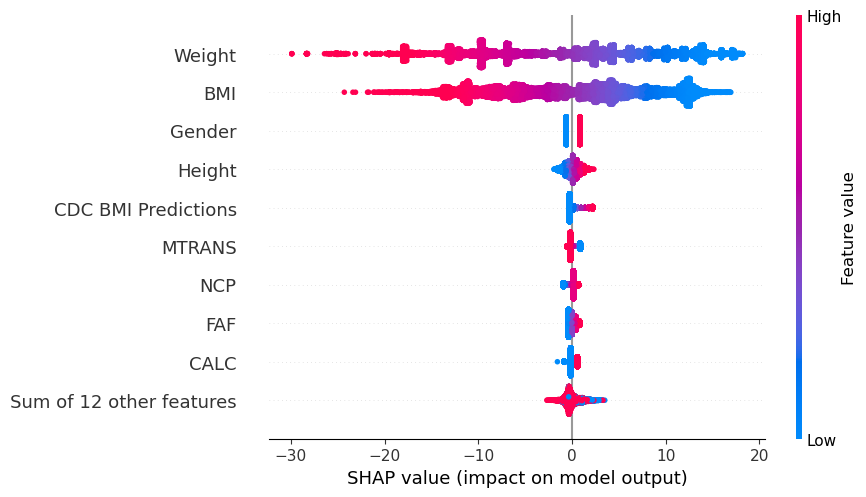

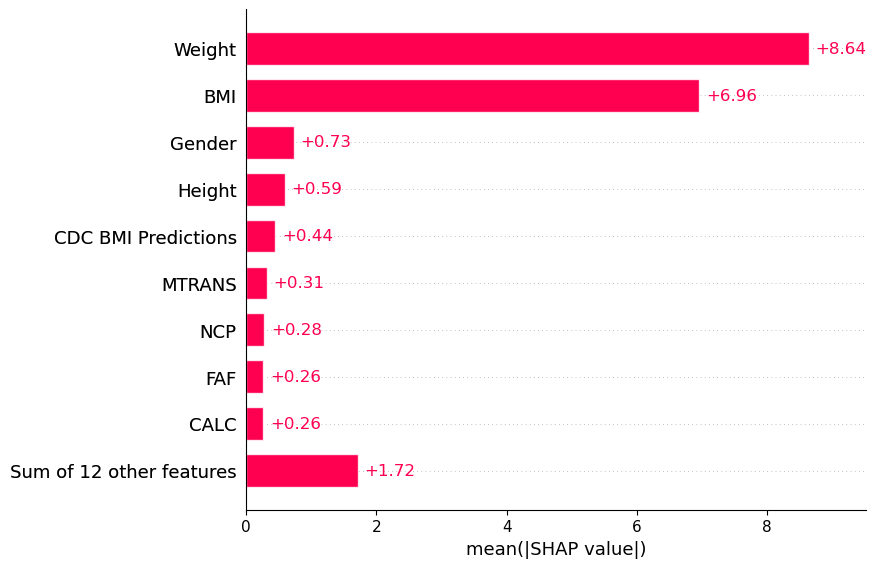

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


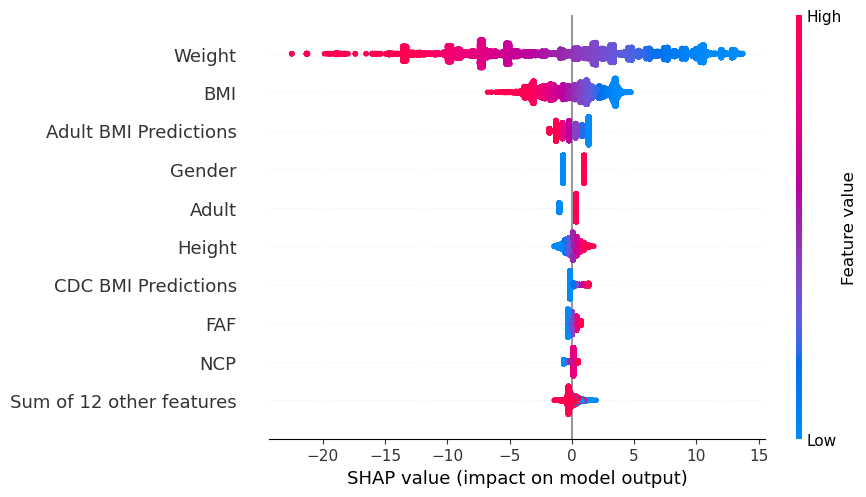

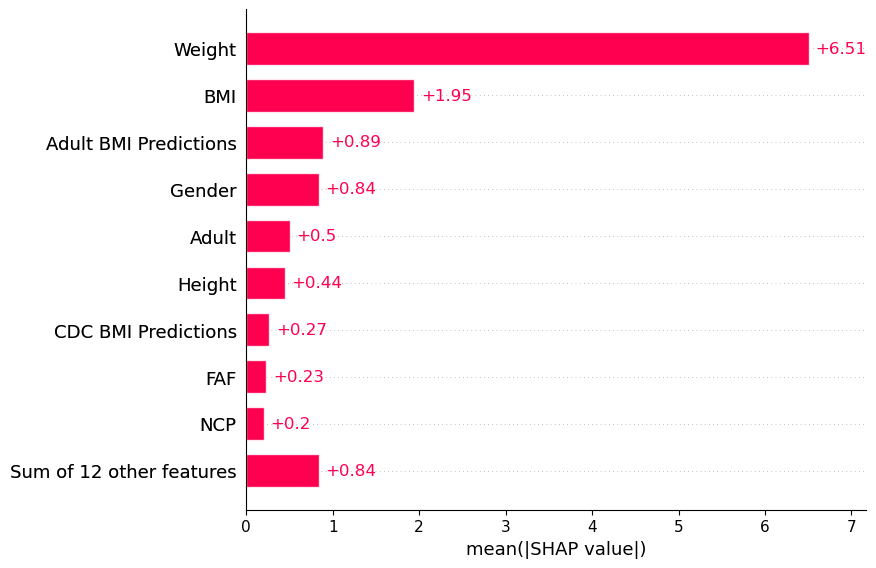

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


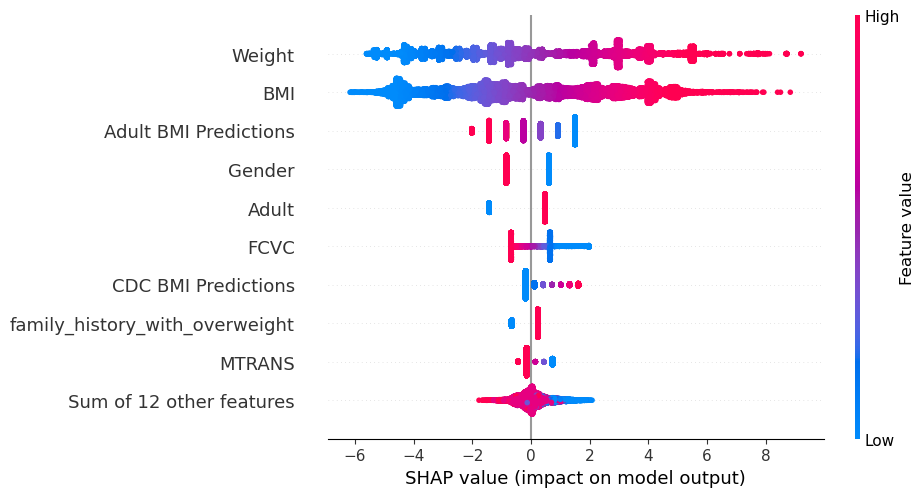

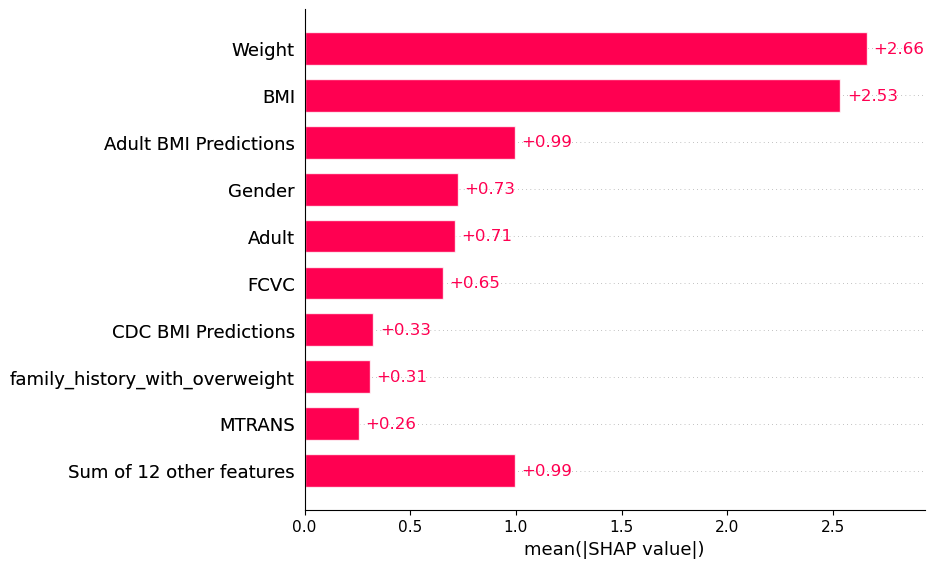

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


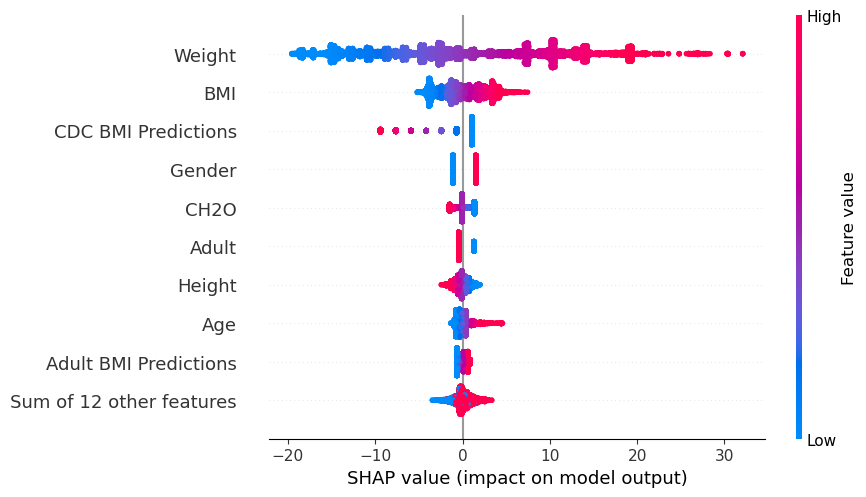

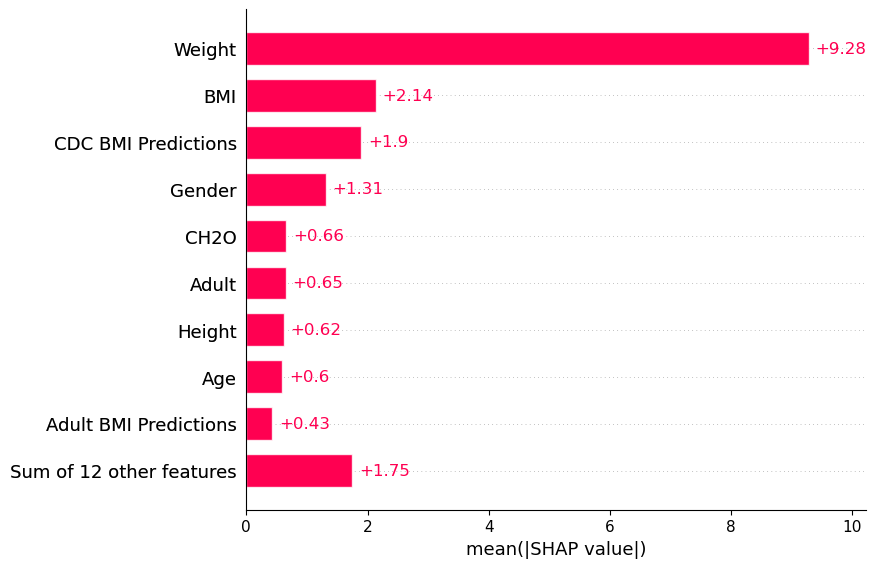

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


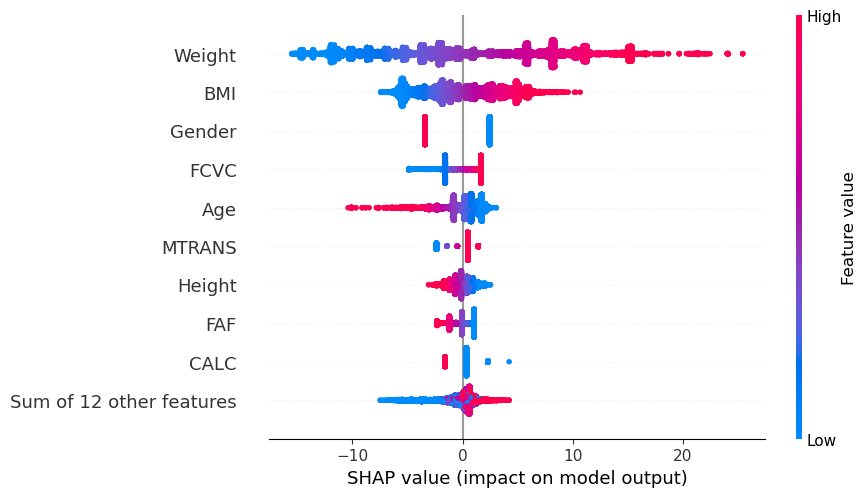

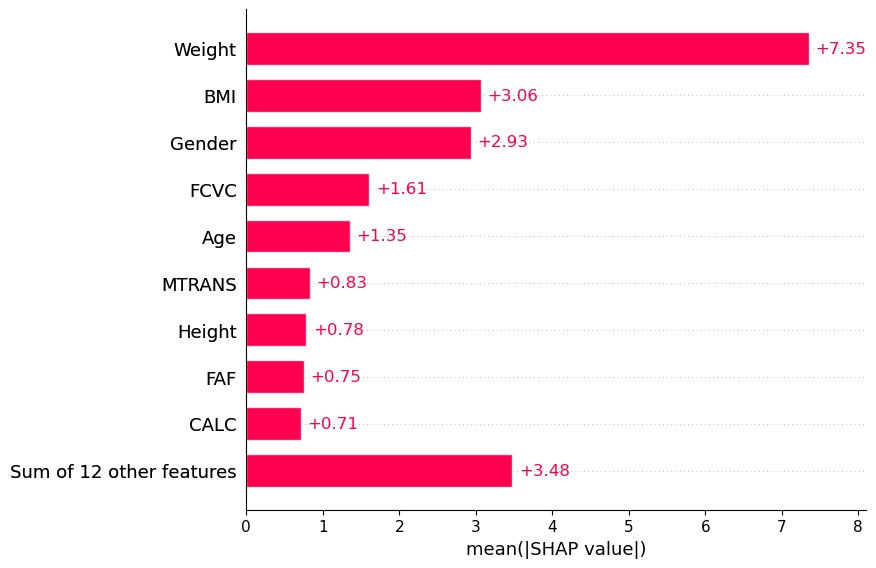

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


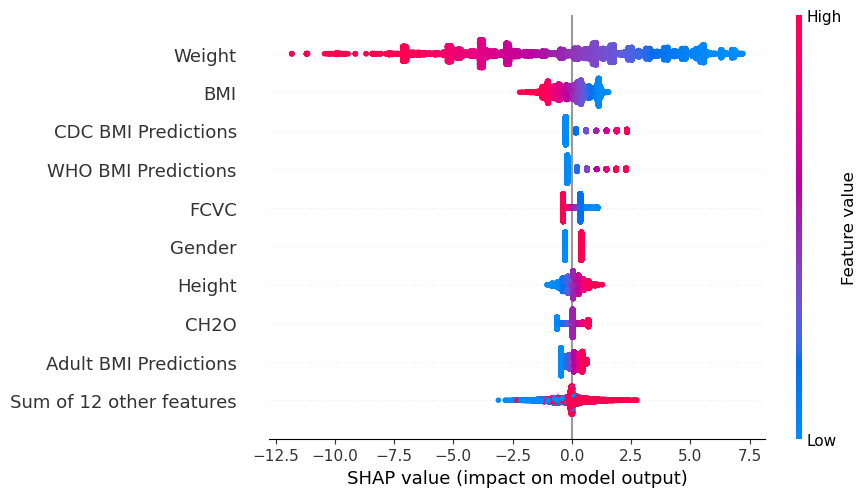

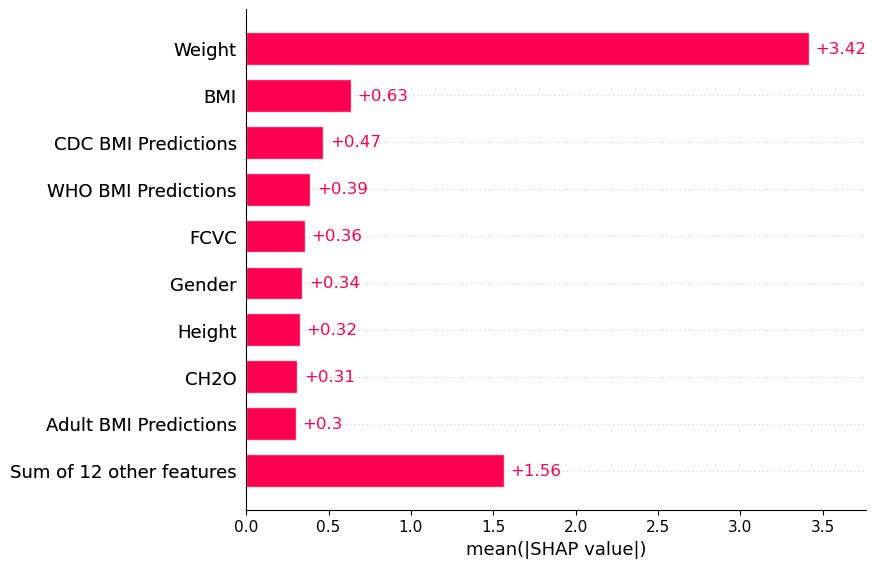

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


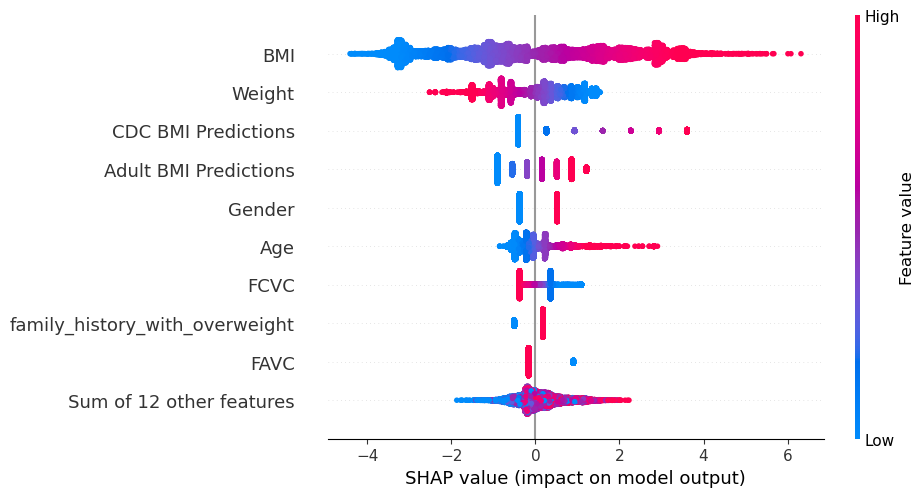

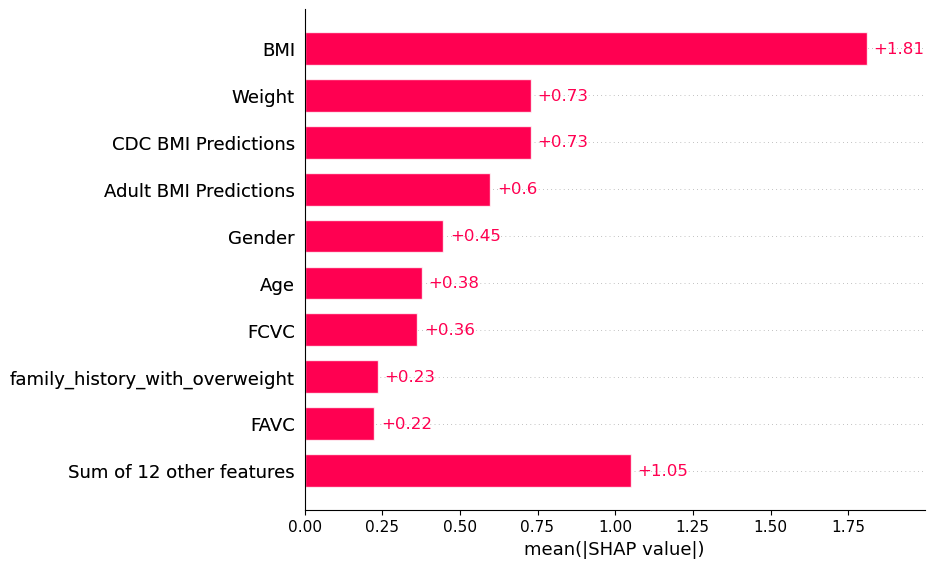

In [33]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])